# Growing Neural Cellular Automata with multi-emoji

## Imports and Notebook Utilities

In [1]:
import os
import io
import pickle
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
from functools import partial

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
	if a.dtype in [np.float32, np.float64]:
		a = np.uint8(np.clip(a, 0, 1)*255)
	return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
	a = np.asarray(a)
	if isinstance(f, str):
		fmt = f.rsplit('.', 1)[-1].lower()
		if fmt == 'jpg':
			fmt = 'jpeg'
		f = open(f, 'wb')
	np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
	a = np.asarray(a)
	if len(a.shape) == 3 and a.shape[-1] == 4:
		fmt = 'png'
	f = io.BytesIO()
	imwrite(f, a, fmt)
	return f.getvalue()

def im2url(a, fmt='jpeg'):
	encoded = imencode(a, fmt)
	base64_byte_string = base64.b64encode(encoded).decode('ascii')
	return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
	display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
	a = np.asarray(a)
	if w is None:
		w = int(np.ceil(np.sqrt(len(a))))
	th, tw = a.shape[1:3]
	pad = (w-len(a))%w
	a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
	h = len(a)//w
	a = a.reshape([h, w]+list(a.shape[1:]))
	a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
	return a

def zoom(img, scale=4):
	img = np.repeat(img, scale, 0)
	img = np.repeat(img, scale, 1)
	return img

class VideoWriter:
	def __init__(self, filename, fps=30.0, **kw):
		self.writer = None
		self.params = dict(filename=filename, fps=fps, **kw)

	def add(self, img):
		img = np.asarray(img)
		if self.writer is None:
			h, w = img.shape[:2]
			self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
		if img.dtype in [np.float32, np.float64]:
			img = np.uint8(img.clip(0, 1)*255)
		if len(img.shape) == 2:
			img = np.repeat(img[..., None], 3, -1)
		self.writer.write_frame(img)

	def close(self):
		if self.writer:
			self.writer.close()

	def __enter__(self):
		return self

	def __exit__(self, *kw):
		self.close()

## Cellular Automata Parameters

In [2]:
CHANNEL_N = 32        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

#TARGET_EMOJI = "🦎😀💥👁🐠🦋🐞🕸🥨🎄" #@param {type:"string"}
TARGET_EMOJI = "🦎😀🐞" #@param {type:"string"}

EXPERIMENT_TYPE = "Regenerating" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

## CA Model and Utilities

In [3]:
import jax
import jax.numpy as jnp

import flax
import flax.linen as nn
from flax.training.train_state import TrainState
from flax.core.frozen_dict import freeze, unfreeze
from flax import traverse_util, serialization

import optax


def load_image(url, max_size=TARGET_SIZE):
	r = requests.get(url)
	img = PIL.Image.open(io.BytesIO(r.content))
	img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
	img = np.float32(img)/255.0
	# premultiply RGB by Alpha
	img[..., :3] *= img[..., 3:]
	return img

def load_emoji(emoji):
	code = hex(ord(emoji))[2:].lower()
	url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
	return load_image(url)


def to_rgba(x):
	return x[..., :4]

def to_alpha(x):
	return jnp.clip(x[..., 3:4], a_min=0.0, a_max=1.0)

def to_rgb(x):
	# assume rgb premultiplied by alpha
	rgb, a = x[..., :3], to_alpha(x)
	return 1.0-a+rgb

@jax.jit
def get_living_mask(x):
	alpha = x[:, :, :, 3:4]
	return nn.max_pool(alpha, window_shape=(3, 3), strides=(1, 1), padding="SAME") > 0.1

@partial(jax.jit)
def make_seed(pad_target, emoji_index):
	x = jnp.zeros((*pad_target.shape[:2], CHANNEL_N))
	x = x.at[pad_target.shape[0]//2, pad_target.shape[1]//2, 3:(CHANNEL_N-len(TARGET_EMOJI))].set(1.0)
	return x.at[pad_target.shape[0]//2, pad_target.shape[1]//2, (CHANNEL_N-len(TARGET_EMOJI))+emoji_index].set(1.0)


class CAModel(nn.Module):
	channel_n = CHANNEL_N
	fire_rate = CELL_FIRE_RATE

	@nn.compact
	def __call__(self, random_key, x, step_size=1.0):
		pre_life_mask = get_living_mask(x)

		# Perceive with depthwise convolution
		y = nn.Conv(features=3*x.shape[-1], kernel_size=(3, 3), padding="SAME", feature_group_count=x.shape[-1], use_bias=False, name="perceive")(x)

		# Update
		dx = nn.relu(nn.Conv(features=256, kernel_size=(1, 1))(y))
		dx = nn.Conv(features=self.channel_n, kernel_size=(1, 1), kernel_init=nn.initializers.zeros)(dx) * step_size
		update_mask = jax.random.uniform(random_key, shape=(*x.shape[:-1], 1), minval=0., maxval=1.) <= self.fire_rate
		x += dx * update_mask

		post_life_mask = get_living_mask(x)
		life_mask = pre_life_mask & post_life_mask
		return x * life_mask

	@partial(jax.jit, static_argnames=("self",))
	def _get_kernel(self, angle=0.):
		identify = jnp.array([0., 1., 0.])
		identify = jnp.outer(identify, identify)
		dx = jnp.outer(jnp.array([1., 2., 1.]), jnp.array([-1., 0., 1.])) / 8.0  # Sobel filter
		dy = dx.T
		c, s = jnp.cos(angle), jnp.sin(angle)
		kernel = jnp.stack([identify, c*dx-s*dy, s*dx+c*dy], axis=-1)[:, :, None, :]
		kernel = jnp.tile(kernel, (1, 1, 1, self.channel_n))
		return kernel

	def set_kernel(self, params, angle=0.):
		kernel = self._get_kernel(angle)
		params = unfreeze(params)
		params["params"]["perceive"]["kernel"] = kernel
		params = freeze(params)
		return params

	def get_mask(self, params):
		flat_params = traverse_util.flatten_dict(params, sep="/")
		flat_params = dict.fromkeys(flat_params, False)

		for key in flat_params:
			if "perceive" in key:
				flat_params[key] = True
		return freeze(traverse_util.unflatten_dict(flat_params, sep="/"))

  PyTreeDef = type(jax.tree_structure(None))

  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "



# Training

## Train Utilities (SamplePool, Model Export, Damage)

In [4]:
class SamplePool(flax.struct.PyTreeNode):
	samples: jnp.ndarray
	targets: jnp.ndarray

	@classmethod
	def init(cls, random_key, pad_targets):
		emoji_indices = jax.random.randint(random_key, (POOL_SIZE,), minval=0, maxval=len(TARGET_EMOJI))
		seeds = jax.vmap(make_seed, in_axes=(None, 0))(pad_targets[0], emoji_indices)
		targets = jnp.take(pad_targets, emoji_indices, axis=0)
		return cls(samples=seeds, targets=targets)

	@partial(jax.jit, static_argnames=("n",))
	def sample(self, random_key, n):
		idx = jax.random.choice(random_key, POOL_SIZE, shape=(n,), replace=False)
		batch = jnp.take(self.samples, idx, axis=0)
		targets = jnp.take(self.targets, idx, axis=0)
		return idx, batch, targets

	@jax.jit
	def commit(self, idx, batch, targets):
		samples = self.samples.at[idx].set(batch)
		targets = self.targets.at[idx].set(targets)
		return self.replace(samples=samples, targets=targets)

def make_circle_masks(random_key, n, h, w):
	x = jnp.linspace(-1.0, 1.0, w)[None, None, :]
	y = jnp.linspace(-1.0, 1.0, h)[None, :, None]
	random_key_1, random_key_2 = jax.random.split(random_key)
	center = jax.random.uniform(random_key_1, shape=(2, n, 1, 1), minval=-0.5, maxval=0.5)
	r = jax.random.uniform(random_key_2, shape=(n, 1, 1), minval=0.1, maxval=0.4)
	x, y = (x-center[0])/r, (y-center[1])/r
	mask = x*x+y*y < 1.0
	return mask

def export_model(params, base_fn):
    state_dict = serialization.to_state_dict(params)
    with open(base_fn, "wb") as params_file:
        pickle.dump(state_dict, params_file)

def generate_pool_figures(pool, step_i):
	tiled_pool = tile2d(to_rgb(pool.samples[:49]))
	fade = np.linspace(1.0, 0.0, 72)
	ones = np.ones(72)
	tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None]
	tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
	tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
	tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
	imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
	vis0 = np.hstack(np.array(to_rgb(x0)))
	vis1 = np.hstack(np.array(to_rgb(x)))
	vis = np.vstack([vis0, vis1])
	imwrite('train_log/batches_%04d.jpg'%step_i, vis)
	print('batch (before/after):')
	imshow(vis)

def plot_loss(loss_log):
	pl.figure(figsize=(10, 4))
	pl.title('Loss history (log10)')
	pl.plot(np.log10(loss_log), '.', alpha=0.1)
	pl.show()


## Choose Target Image

  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)



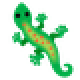

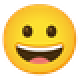

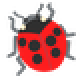

In [5]:
#url = 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/planaria2_48.png?raw=true'
#target_img = load_image(url, 48)

target_imgs = jnp.stack([load_emoji(target_emoji) for target_emoji in TARGET_EMOJI], axis=0)
for i in range(len(TARGET_EMOJI)):
    imshow(zoom(to_rgb(target_imgs[i]), 2), fmt='png')

## Initialize Training

In [6]:
random_key = jax.random.PRNGKey(42)
p = TARGET_PADDING
pad_targets = jnp.pad(target_imgs, ((0, 0), (p, p), (p, p), (0, 0)))
h, w = pad_targets.shape[1:3]
seed = make_seed(pad_targets[0], 0)[None, ...]

def loss_f(x, target):
	return jnp.mean(jnp.square(to_rgba(x) - target), axis=(-1, -2, -3))

ca = CAModel()
random_key, random_subkey_1, random_subkey_2 = jax.random.split(random_key, 3)
params = ca.init(random_subkey_1, random_subkey_2, seed)
params = ca.set_kernel(params)

loss_log = []

lr = 2e-3
lr_sched = optax.linear_schedule(init_value=lr, end_value=0.1*lr, transition_steps=2000)
trainer = optax.adam(learning_rate=lr_sched)

# zero update
def zero_grads():
	def init_fn(_):
		return ()

	def update_fn(updates, state, params=None):
		return jax.jax.tree_util.tree_map(jnp.zeros_like, updates), ()
	return optax.GradientTransformation(init_fn, update_fn)

tx = optax.multi_transform({False: optax.adam(learning_rate=lr_sched),
			    			True: zero_grads()}, ca.get_mask(params))

train_state = TrainState.create(
	apply_fn=ca.apply,
	params=params,
	tx=tx)

loss0 = loss_f(seed, 0)
random_key, random_subkey = jax.random.split(random_key, 2)
pool = SamplePool.init(random_subkey, pad_targets)

!mkdir -p train_log && rm -f train_log/*

  label_set = set(jax.tree_leaves(labels))



## Training Loop

batch (before/after):


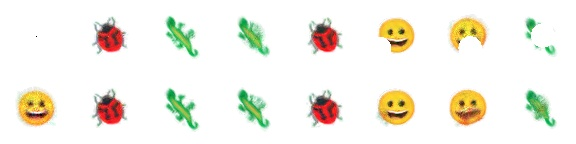

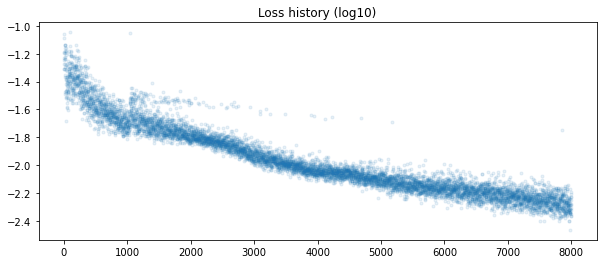

 step: 8001, log10(loss): -2.229

In [7]:
@jax.jit
def scan_apply(carry, random_key):
	params, batch = carry
	batch_ = train_state.apply_fn(params, random_key, batch)
	return (params, batch_), (jnp.squeeze(batch_, axis=0),)

@partial(jax.jit, static_argnames=("iter_n",))
def train_step(state, random_key, batch, targets, iter_n):
	def loss_fn(params):
		random_keys = jax.random.split(random_key, iter_n)
		(params, predictions), _ = jax.lax.scan(scan_apply, (params, batch), random_keys, length=iter_n)
		return loss_f(predictions, targets).mean(), predictions

	(loss, predictions), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
	state = state.apply_gradients(grads=grads)

	return state, loss, predictions

for i in range(8000+1):
	random_key, random_subkey_1, random_subkey_2, random_subkey_3, random_subkey_4, random_subkey_5 = jax.random.split(random_key, 6)

	if USE_PATTERN_POOL:
		idx, batch, targets = pool.sample(random_subkey_1, BATCH_SIZE)
		loss_rank = jnp.flip(jnp.argsort(loss_f(batch, targets)))
		idx = jnp.take(idx, loss_rank, axis=0)
		batch = jnp.take(batch, loss_rank, axis=0)
		targets = jnp.take(targets, loss_rank, axis=0)
		emoji_index = jax.random.randint(random_subkey_2, shape=(), minval=0, maxval=len(TARGET_EMOJI))
		batch = batch.at[0].set(make_seed(pad_targets[0], emoji_index))
		targets_ = targets.at[0].set(pad_targets[emoji_index])
		if DAMAGE_N:
			damage = 1.0-make_circle_masks(random_subkey_3, DAMAGE_N, h, w)[..., None]
			batch = batch.at[-DAMAGE_N:].set(batch[-DAMAGE_N:] * damage)
	else:
		batch = np.repeat(seed, BATCH_SIZE, 0)

	iter_n = jax.random.randint(random_subkey_4, shape=(), minval=64, maxval=96)
	train_state, loss, batch_ = train_step(train_state, random_subkey_5, batch, targets_, int(iter_n))

	if USE_PATTERN_POOL:
		pool = pool.commit(idx, batch_, targets_)

	step_i = len(loss_log)
	loss_log.append(loss)

	if step_i % 10 == 0:
		generate_pool_figures(pool, step_i)
	if step_i % 100 == 0:
		clear_output()
		visualize_batch(batch, batch_, step_i)
		plot_loss(loss_log)
		export_model(train_state.params, "train_log/%04d"%step_i)

	print("\r step: %d, log10(loss): %.3f"%(len(loss_log), np.log10(loss)), end="")

In [112]:
@jax.jit
def scan_apply(carry, random_key):
	params, batch = carry
	batch_ = train_state.apply_fn(params, random_key, batch)
	return (params, batch_), (jnp.squeeze(batch_, axis=0),)

In [108]:
seed = make_seed(pad_targets[0], 2)
seed = jnp.expand_dims(seed, axis=0)

In [126]:
seed = make_seed(pad_targets[0], 0)
seed = seed.at[72//2, 72//2, -3:-1].set(1.0)
seed = jnp.expand_dims(seed, axis=0)

In [121]:
seed = make_seed(pad_targets[0], 0)
seed = seed.at[72//2, 72//2, -1].set(1.0)
seed = jnp.expand_dims(seed, axis=0)

In [122]:
seed[0, 72//2, 72//2, :]

DeviceArray([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             0., 1.], dtype=float32)

In [127]:
iter_n = 1_000
random_keys = jax.random.split(random_key, iter_n)
(params, prediction), (predictions,) = jax.lax.scan(scan_apply, (train_state.params, seed), random_keys, length=iter_n)

batch (before/after):


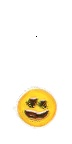

In [128]:
visualize_batch(seed, prediction, iter_n)

batch (before/after):


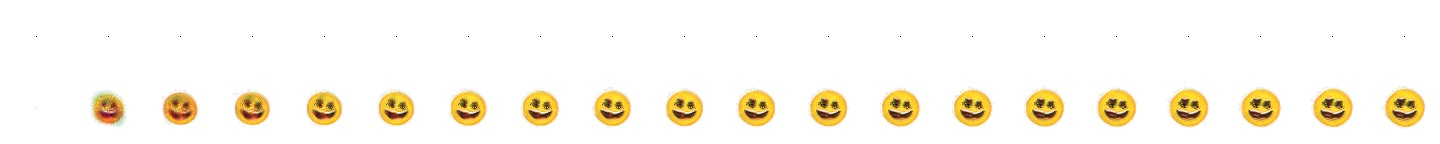

In [129]:
idx = jnp.linspace(0, iter_n, 20, dtype=jnp.int32)
visualize_batch(jnp.repeat(seed, len(idx), axis=0), predictions[idx], iter_n)